# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5) , (0.5, 0.5, 0.5)),
])

transform_valid = transforms.Compose([transforms.ToTensor() , transforms.Normalize((0.5, 0.5, 0.5) , (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([transforms.ToTensor() , transforms.Normalize((0.5, 0.5, 0.5) , (0.5, 0.5, 0.5))])

#batch_size

batch_size = 50


# cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
# testset_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
                    
#Create training set and define training dataloader

train_data = torchvision.datasets.CIFAR10(root = './data' , train = True , transform = transform_train , download = True)
trainloader = torch.utils.data.DataLoader(train_data , batch_size = batch_size , shuffle = True , num_workers = 4)

#Validation data & loader
valid_data = torchvision.datasets.CIFAR10(root = './data' , train = False , transform = transform_valid , download = True)
validloader = torch.utils.data.DataLoader(valid_data , batch_size = batch_size , shuffle = True , num_workers = 4)
                                    

# Create test set and define test dataloader
test_data = torchvision.datasets.CIFAR10(root = './data' , train = False , transform = transform_test , download = True) 
testloader= torch.utils.data.DataLoader(test_data , batch_size = batch_size , shuffle = False , num_workers = 4)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()



### Plot random 'five' images

Files already downloaded and verified
plane


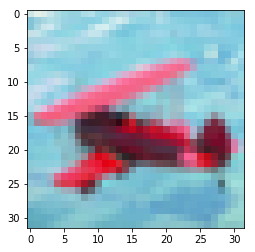

plane


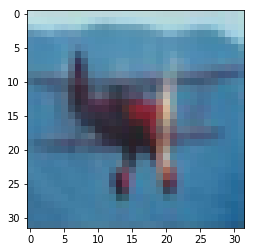

car


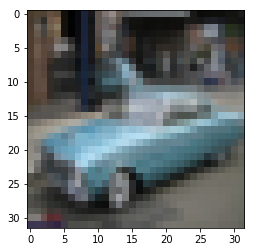

bird


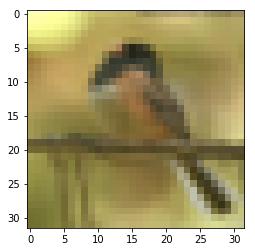

dog


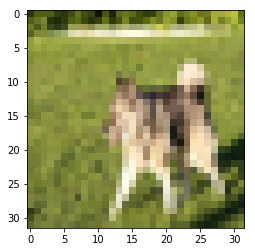

In [4]:
#non-normalized loader to view images
view = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('CIFAR10/car',
                                   transform = transforms.ToTensor(),
                                   download = True),
                                   batch_size = 50,
                                   shuffle = True,
                                   )

show5(view)

#### Images looks blurred a little bit but much better than normalized loaders.

####  ==/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\==
#### ==/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\==

### Look on CIFAR10 training , validation , testing length

In [5]:
# Explore data

print('Training set has:', len(train_data))
print('Validation set has:', len(valid_data))
print('Testing set has:', len(test_data))

Training set has: 50000
Validation set has: 10000
Testing set has: 10000


#### Everything looks fine !.

####  ==/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\==
#### ==/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\==

### Look on dimensions and properties

In [6]:
images , labels = next(iter(trainloader))

print(f'Batch_size:{images.shape[0]}\nChanels:{images.shape[1]}\nDimensions:{images.shape[2]} , {images.shape[3]}')

print(f'labels Batch_size:{labels.shape[0]}')
print(f'================\nFlattening images:{images.view(images.shape[0] , -1).shape}')

print('\n',images.shape)

Batch_size:50
Chanels:3
Dimensions:32 , 32
labels Batch_size:50
Flattening images:torch.Size([50, 3072])

 torch.Size([50, 3, 32, 32])


####  ==/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\==
#### ==/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\====/\==/\==

### Tests and Calculations on dimensions

In [7]:
#test 

print(images.shape)


pool = nn.MaxPool2d(2,2)

cnv1 = nn.Conv2d( 3 , 6 , kernel_size=(5))
x = cnv1(images)
print(x.shape)


# x = pool(x)
# print(x.shape)

cnv2 = nn.Conv2d(6 , 18 , kernel_size = 5  )
x = cnv2(x)
print(x.shape)

x = pool(x)
print(x.shape)


cnv3 = nn.Conv2d(18 , 32 , kernel_size=(3,3) , padding = 4 , stride = 2 )
x = cnv3(x)

print(x.shape)


x = pool(x)
print(x.shape)

x = x.view(-1 , 32*4*4)
print(x.shape)

fc1 = nn.Linear(32*4*4 , 120)
x = fc1(x)
print(x.shape)

fc2 = nn.Linear(120 , 84)
x = fc2(x)

print(x.shape)


fc3 = nn.Linear(84 , 10)
x = fc3(x)
print(x.shape)




torch.Size([50, 3, 32, 32])
torch.Size([50, 6, 28, 28])
torch.Size([50, 18, 24, 24])
torch.Size([50, 18, 12, 12])
torch.Size([50, 32, 9, 9])
torch.Size([50, 32, 4, 4])
torch.Size([50, 512])
torch.Size([50, 120])
torch.Size([50, 84])
torch.Size([50, 10])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [8]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model , self).__init__()
        # c1 , c2 , pool , c3 , pool , view , fc1 , fc2 , fc3
        
        self.cnv1 = nn.Conv2d(3 , 6 , 5) #6 x 28 x 28
       
        self.cnv2 = nn.Conv2d(6 , 18 , 5)#18 x 24 x 24
        
        self.pool= nn.MaxPool2d(2,2) #18 x 12 x 12        
        
        # extra
        
        self.cnv3 = nn.Conv2d(18 , 32 , 3 , padding = 4 , stride = 2)
        
        
        #dropouts functions
        self.drop = nn.Dropout(0.2)
        self.drop1= nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(32 * 4 * 4 , 120)
        
        self.fc2 = nn.Linear(120 , 84)
        
        self.fc3 = nn.Linear(84 , 10)
        
    
    def forward(self , x):
        
        #Conv layers
        x = self.cnv1(x)
        
        x = F.relu(x)
        
        x = self.cnv2(x)
        x = F.relu(x)

        #pool
        x = self.pool(x)
        
        x = self.cnv3(x)
        x = F.relu(x)
        
        #pool
        x = self.pool(x)
        
        #view
        x = x.view(-1 , 32 * 4 * 4)
        
        #Fully connected layers
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        #Activation function
        x = F.log_softmax(self.fc3(x) , dim = 1)
        
        
        return x
        
        


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
#Initialization
from torch.optim import lr_scheduler
from torch.optim import Adagrad
model = Model()

# Loss function
criterion = nn.NLLLoss()



## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
#This ensures that training is occured on gpu(cuda) not cpu
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu') 


#Number of epoches
epoches = 50

#Moving model to cuda
model.to(device)

# initializing recording lists
trainlosses , validlosses , validaccs = [] ,[] , []

#moving model to training mode

model.train()



##### iterations over epoches #####
#####    training starts      #####

for e in range(epoches):
    runloss = 0
    validloss = 0
    
    #evaluation variables
    index = 0
    batch_num = 0
    
    
    #modifying learning rate
    if e <= 20:
        optimizer = optim.SGD(model.parameters() , lr = 0.004  , momentum = 0.9 ,  weight_decay=5e-4)
    elif e >= 21 and e <= 30:
        optimizer = optim.Adam(model.parameters() , lr = 0.003 ,  weight_decay=5e-4)
        
    else: 
        optimizer = optim.Adam(model.parameters() , lr = 0.001 , weight_decay=5e-4)
        
    for images,labels in trainloader:
        index +=1
        
        #loading/transfering data into gpu
        images , labels = images.to(device) , labels.to(device)        
        
        optimizer.zero_grad()
        
        training_output = model(images)
        
        
        loss = criterion(training_output , labels)
        loss.backward()
        
        
        optimizer.step()
        
        #calculating training loss
        runloss+=loss.item()
        
        if index % 250 == 0:
            
            accuracy = 0
            validloss = 0
            model.eval()
            
            #Grad is removed while validating to increase performance
            with torch.no_grad():
                
                
                batch_num += 1
                
                for images , labels in validloader:
                    
                    
                    images , labels = images.to(device) , labels.to(device)
                    
                    validation_output = model(images)
                    
                    loss = criterion(validation_output , labels)
                   
                
                    validloss+= loss.item()
                    
                    #accuracy calculations 
                    probs = torch.exp(validation_output)

                    top_ps , top_class = probs.topk(1 , dim = 1)

                    equals = top_class == labels.view(top_class.shape)

                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            #accuracy 
            ac = accuracy / len(validloader)
        
            validaccs.append(ac)
            
            #training loss difference / change 
            tlc = runloss / len(trainloader)
            trainlosses.append(tlc)
            
            #validation loss difference / change
            vlc = validloss / len(validloader)
            validlosses.append(vlc)
            
            print("==/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====")       
            print(f'At epoch {e} out of {epoches} on 250 batch: validation #{batch_num}')
            print(f'train loss is {tlc:.4f}')
            print(f'validation loss is {vlc:.4f}')
            print(f'validation accuracy is {ac:.4f}')
            
            
            
            runloss = 0
            
        #moving model to training mode
            model.train()
            

==/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====
At epoch 0 out of 50 on 250 batch: validation #1
train loss is 0.5760
validation loss is 2.3025
validation accuracy is 0.1000
==/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====
At epoch 0 out of 50 on 250 batch: validation #2
train loss is 0.5755
validation loss is 2.3016
validation accuracy is 0.1199
==/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====
At epoch 0 out of 50 on 250 batch: validation #3
train loss is 0.5750
validation loss is 2.2951
validation accuracy is 0.1310
==/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====
At epoch 0 out of 50 on 250 batch: validation #4
train loss is 0.5630
validation loss is 2.1415
validation accuracy is 0.2041
==/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====/*\==/*\====
At epoch 1 out of 50 on 250 batch: validation #1
train loss i

Plot the training loss (and validation loss/accuracy, if recorded).

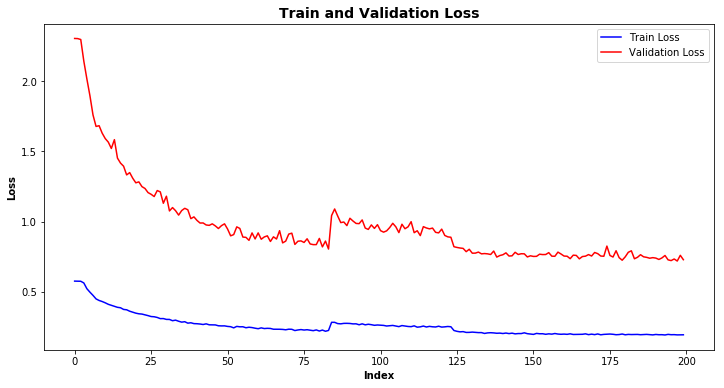

In [11]:
# Index --> number of occurance
plt.figure(figsize = [12,6] )
plt.plot(trainlosses , label = 'Train Loss' , color = 'blue')
plt.plot(validlosses , label = 'Validation Loss' , color = 'red')


plt.title("Train and Validation Loss", color = 'black' , size = 14 , weight='bold')
plt.xlabel('Index', color = 'black' , size = 10 , weight='bold')
plt.ylabel('Loss', color = 'black' , size = 10 , weight='bold')
plt.legend()


plt.show();

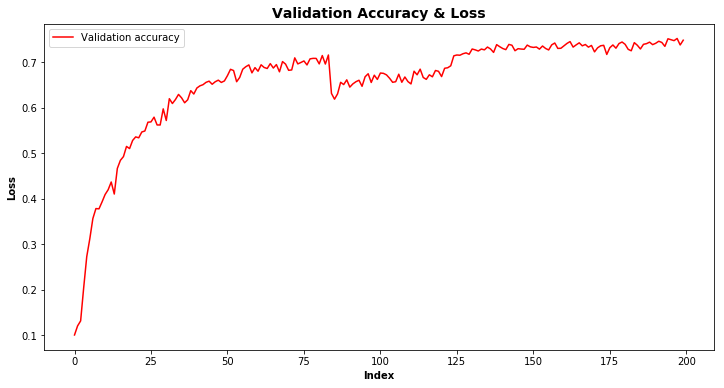

In [12]:
#Index --> Number of occurance
plt.figure(figsize = [12,6] )

plt.plot(validaccs , label = 'Validation accuracy' , color = 'red')

plt.title('Validation Accuracy & Loss' , color = 'black' , size = 14 , weight='bold')
plt.xlabel('Index' , color = 'black' , size = 10 , weight='bold')
plt.ylabel('Loss', color = 'black' , size = 10 , weight='bold')
plt.legend()

plt.show();

### Conclusion:

I tried many different architictures but finally used this one. it is a four convoulotional layers with three connected layer and two maxpools. `conv1 -> conv2 --> pool --> c3 --> pool --> view --> fc1 --> fc2 --> fc3`. I used `log_softmax` as an activation function and `relu` for each layer. training loss and validation loss was close to each other no suspicios on `Overfitting` or `Underfitting`. validation accuracy was 74% to 75%. 


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
# #moving model to evaluating mode
model.eval()
test_loss = 0
test_accuracy = 0
with torch.no_grad():
                for images , labels in testloader:

                    images , labels = images.to(device) , labels.to(device)

                    test_output = model(images)

                    loss = criterion(test_output , labels)

                    test_loss += loss.item()

                    #Calculating accuracy
                    probs = torch.exp(test_output)

                    top_ps , top_class = probs.topk(1 , dim = 1)

                    equals = top_class == labels.view(top_class.shape)

                    test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()   
                    
print('Model Accuracy is {:.4f}'.format(test_accuracy/len(testloader)))
print('Model Test Loss is {:.4f}'.format(test_loss/len(testloader)))

Model Accuracy is 0.7490
Model Test Loss is 0.7284


## Saving your model
Using `torch.save`, save your model for future loading.

In [14]:
#Last overview
print(model)


torch.save(model.state_dict() , 'Model')

Model(
  (cnv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cnv2): Conv2d(6, 18, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnv3): Conv2d(18, 32, kernel_size=(3, 3), stride=(2, 2), padding=(4, 4))
  (drop): Dropout(p=0.2)
  (drop1): Dropout(p=0.25)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

I recommend to build a model instead of buying one. It was possible to achieve `75%` accuracy score with simple effort. I think if more effort done on this model it will achieve higher accuracy score.


-Comparing to `Detectocorp's` model, my model got higher accuracy score with `75%` higher that Detectocorp's model `(70%)`.

-My model seems too simple against advanced solutions. All i did is simple tests between layers and dimensions unlike who made these advanced solutions which mostly put more efforts than i did.

-I achieved `75%` accuracy score by applying 50 epochs, Four `Convoultional Layers` with one pooling function after the second and third layer, three `Fully Connected Layers`, And of course used a non-linear function (relu) for each layer and finally one activation function (Log_softmax) at the end. I used three different optimizers (SGD , Adam , Adam) , i could have used scheduler for second and third optimizers but i faced some unknown errors that i couldn't solve. I also used NLLLoss as a loss function. I have managed to modify hyperparameters of layers and optimizers to achieve this score.

    flow: conv1 -> conv2 --> pool --> c3 --> pool --> view --> fc1 --> fc2 --> fc3


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).